In [3]:
import numpy as np
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import sklearn
import sounddevice as sd
import soundfile as sf
from AimTTI_PLP import dev_TTI_PLP
from time import sleep
import csv  
from csv import DictWriter

def metal_to_number(metal):
    if metal=="Copper":
        return 2
    elif metal== "Brass":
        return 0
    elif metal== "Aluminium":
        return 1
    elif metal == "Steal":
        return 3
    else:
        print("incorrect spelling")
        return "ERROR"
        
#GET TENSOR FOR SPECTROGRAM
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = torchaudio.load(aud)
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

#VIEW SPECTROGRAM
def view_specrogram(aud,n_fft=1024, samplerate = 22050, hop_len=None):
    samples, sample_rate=librosa.load(aud, sr = samplerate)
    print(sample_rate)
    audio_stft = librosa.core.stft(samples, hop_length=hop_len, n_fft=n_fft)# gathering the absolute values for all values in our audio_stft 
    spectrogram = np.abs(audio_stft)# Converting the amplitude to decibel
    #librosa.feature.melspectrogram(S=spectrogram,sr=sample_rate, fmax=4000)
    #librosa.feature.spectral_bandwidth(*, y=None, sr=44100, S=None, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, pad_mode='constant', freq=None, centroid=None, norm=True, p=2)
    log_spectro = librosa.amplitude_to_db(spectrogram)# Plotting the short-time Fourier Transformation
    plt.figure(figsize=(20, 5))# Using librosa.display.specshow() to create our spectrogram
    librosa.display.specshow(log_spectro, sr=sample_rate, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(label='Decibels')
    #plt.title('Spectrogram (dB)', fontdict=dict(size=18))
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()
    
def record_and_bang(duration,fs,channels, port,wav_name, power = 12):
    TTI = dev_TTI_PLP(portstr=port)    
    idn=TTI.get_identity()
    print('GetIdentity (*IDN?) in AimTTI_PLP.py returns: {}'.format(idn))
    TTI._Vlimit = power
    TTI.SetVoltage = power
    TTI.SetCurrent = 3
    TTI.OutputOff
    sleep(0.1)
    myrec = sd.rec(int(duration*fs), samplerate=fs, channels = channels, blocking = False)
    for i in range(10): #it was 10
        sleep(0.6)
        TTI.OutputOn
        sleep(0.6)
        TTI.OutputOff
    TTI.close()
    sd.wait()
    sf.write(wav_name, myrec, fs)


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 28 13:54:29 2016
Python3 update v0 Tue Mar 27 2018
Python3 update v2 Thu Aug 2 2018
update v3 Fri Apr 3 2020 - added error trapping and (hopefully) informative error messages. 

Requires:
    Thorlabs APT server dll installed in default location and configured for attached device.
    thorlabs_apt package (0.2 tested) installed as requirement of level2labs
    
@author: Aidan Hindmarch
"""

from os import environ, pathsep
from platform import system

if not system() == 'Windows':
    raise RuntimeError('Thorlabs APT device drivers only supported under Windows OS.')

termpath = environ['PATH']
if not r'Thorlabs\APT\APT Server' in termpath:
    environ['PATH'] = r'C:\Program Files (x86)\Thorlabs\APT\APT Server' + pathsep + r'C:\Program Files\Thorlabs\APT\APT Server' + pathsep + termpath
# Prepend default location of thorlabs apt server apt.dll to local PATH for terminal.
# This is required so that when we import thorlabs_apt module the _load_library
# function which automatically runs in core.py is able to find the system APT.dll by
# filename = ctypes.util.find_library("APT") - which searches the PATH.

try:
    from thorlabs_apt import core as apt_rs
except Exception as e:
    raise RuntimeError('Importing thorlabs_apt package failed (likely related to locating/loading APT.dll) with exception: ', e)

from time import sleep

class Rotation_Stage(object):
    '''
    Class to control a Thorlabs rotation stage using APT command library.
    Code is a simplified wrapper to thorlabs_apt package from PyPI.
    Defines the following user methods:
        rotate(speed=10.0) - starts constant angular velocity rotation (deg/sec) up to limit of motor

    Defines the following properties:
        identity - Get hardware information from motor controller. Returns tuple of strings containing hardware information.
        home - Send motor to home position. Returns True.
        angle - Property to Get or set motor position (in degrees, mod 360).
        stop - stop constant rotation. Returns True.
    '''
    def __init__(self, device_index=0):
        try:
            motor = apt_rs.list_available_devices()[device_index][1]
        except IndexError as e:
            raise RuntimeError('Cannot detect Thorlabs rotation stage controller. Check power and USB connection cable, then power-cycle the rotation stage controller to re-establish connection to PC.') from e
            
        self._motor = apt_rs.Motor(motor)
        self._acc, self._vmax =self._motor.get_velocity_parameter_limits()
        self._defaultv = 10.0
        self._defaultacc = 10.0
        self._motor.set_velocity_parameters(0.0, self._defaultacc, self._defaultv)

    @property
    def identity(self):
        '''
        Get hardware information from motor controller.
        Returns tuple of strings containing hardware information
        '''
        self._motor.identify()
        return self._motor.hardware_info

    @property
    def home(self):
        '''
        Send motor to home position.
        returns True
        '''
        self._motor.move_home(True)
        return True

    @property
    def angle(self):
        '''
        Property to Get or set motor position (in degrees, mod 360).
        '''
        return self._motor.position

    @angle.setter
    def angle(self, set_angle):
        self._motor.move_to(set_angle, True)

    def rotate(self, speed=10.0):
        '''
        Start rotation at constant angular velocity (degrees per second) set by speed (up to motor limit)
        returns True
        '''

        if (speed > self._vmax):
            speed = self._vmax
        #print('speed = {}').format(speed)
        self._motor.set_velocity_parameters(0.0, self._acc, float(speed))
        self._motor.move_velocity(2)
        return True

    @property
    def stop(self):
        '''
        Stop constant rotation.
        returns True
        '''
        self._motor.stop_profiled()
        sleep(1)
        self._motor.set_velocity_parameters(0.0, 10.0, 10.0)
        return True

# for j in range(2):
#     print(apt_rs.list_available_devices())
#     rs = Rotation_Stage()
#     print(rs.identity)
#     rs.home
#     print('homed')
#     for i in range(5):
#         rs.angle = i*45
#         angle=i*45

In [2]:
#AUTOMATION with constant power
field_names = ['AUDIO','METAL','Y', "DISTANCE", "ANGLE", "SHAPE", "AREA", "POWER", "THICK"]
distance=24 #mm away from metal to tip of microphone
angle=90 #angle from metal in degrees
shape="rectangle" #CHANGE THIS
area=3393 #CHANGE THIS
start=True
thickness=6
#location=''
channels=1
duration=13
port='COM9'
metal="Aluminium"#CHNAGE THIS
num=metal_to_number(metal) #brass:0, aluminium:1, copper:2,steel:3 CHANGE THIS
fs=int(44100)
for i in range(1):
    wav_name='fold_1/{}_{}.wav'.format(metal,i+59)
    record_and_bang(duration,fs,channels, port,wav_name)
    dict={'AUDIO':wav_name,'METAL':metal,'Y':num, "DISTANCE":distance, "ANGLE":angle, "SHAPE":shape, "AREA":area, "POWER":power, "THICK": thickness}
    with open('metadata/METADATA.csv', 'a', newline="") as f_object:
    # Pass the file object and a list 
    # of column names to DictWriter()
    # You will get a object of DictWriter
        dictwriter_object = DictWriter(f_object, fieldnames=field_names)
  
    #Pass the dictionary as an argument to the Writerow()
        dictwriter_object.writerow(dict)
  
    #Close the file object
        f_object.close()

GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06


KeyboardInterrupt: 

In [20]:
#AUTOMATION with varying power & angle
field_names = ['AUDIO','METAL','Y', "DISTANCE", "ANGLE", "SHAPE", "AREA", "POWER", "THICK"]
channels=1
duration=13
port='COM9'
fs=int(44100)

##Changeables
distance=24          #mm away from metal to tip of microphone
shape="square"       
area=2704           #mm^2
thickness = 0.7
metal="Steal"
num=metal_to_number(metal)


print(apt_rs.list_available_devices())
rs = Rotation_Stage()
print(rs.identity)
rs.home
print('homed')
#for loops
for i in range(5):
    rs.angle = i*45
    angle=i*45             #centre-of-mic angle to metal in degrees
    for j in range(11):
        wav_name='fold_1/{}_{}.wav'.format(metal,i*11+j+167) #change for Brass
        power = j*2+9.8
        record_and_bang(duration,fs,channels, port,wav_name, power)
        dict={'AUDIO':wav_name,'METAL':metal,'Y':num, "DISTANCE":distance, "ANGLE":angle, "SHAPE":shape, "AREA":area, "POWER":power, "THICK": thickness}
        with open('metadata/METADATA.csv', 'a', newline="") as f_object:

        #Pass the file object and a list of column names to DictWriter() You will get a object of DictWriter
            dictwriter_object = DictWriter(f_object, fieldnames=field_names)

        #Pass the dictionary as an argument to the Writerow()
            dictwriter_object.writerow(dict)

        #Close the file object
            f_object.close()

[(31, 83857315)]
(b'TDC001', b'SW Version 2.0.8', b'TDC001 DC Servo Drive')
homed
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06
GetIdentity (*IDN?

In [21]:
record_and_bang(duration,fs,channels, port,wav_name, power = 30)

GetIdentity (*IDN?) in AimTTI_PLP.py returns: THURLBY THANDAR, PL303-P, 496139, 3.05-4.06


*******************************************

In [33]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (5- USB PnP Sound De, MME (2 in, 0 out)
   2 Microphone (3- USB PnP Sound De, MME (2 in, 0 out)
   3 Microphone Array (Realtek High , MME (2 in, 0 out)
   4 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  5 Speaker/HP (Realtek High Defini, MME (0 in, 2 out)
   6 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   7 Microphone (5- USB PnP Sound Device), Windows DirectSound (2 in, 0 out)
   8 Microphone (3- USB PnP Sound Device), Windows DirectSound (2 in, 0 out)
   9 Microphone Array (Realtek High Definition Audio), Windows DirectSound (2 in, 0 out)
  10 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  11 Speaker/HP (Realtek High Definition Audio), Windows DirectSound (0 in, 2 out)
  12 Speaker/HP (Realtek High Definition Audio), Windows WASAPI (0 in, 2 out)
  13 Microphone (3- USB PnP Sound Device), Windows WASAPI (1 in, 0 out)
  14 Microphone Array (Realtek High Definition Audio), Wind

In [40]:
channels=1
 #brass:0, aluminium:1, copper:2,steel:3 CHANGE THIS
duration=5
fs=int(44100)
myrec = sd.rec(int(duration*fs), samplerate=fs, channels = channels, blocking = False, device = 1)
myrec2 = sd.rec(int(duration*fs), samplerate=fs, channels = channels, blocking = False, device = 2)
sd.wait()


In [47]:
print(myrec)
print(myrec2)
uberrec=[]
for i in range(len(myrec)):
    uberrec.append(myrec[i])
    uberrec.append(myrec2[i])
print(uberrec)

[[5.3364161e-20]
 [8.8982452e-43]
 [1.2525575e-08]
 ...
 [8.8982452e-43]
 [2.5706004e-07]
 [8.8982452e-43]]
[[-0.00186157]
 [-0.00222778]
 [-0.00231934]
 ...
 [-0.00054932]
 [-0.00057983]
 [-0.00061035]]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [43]:

sf.write('test.wav', myrec, fs)
print(myrec)

[[5.3364161e-20]
 [8.8982452e-43]
 [1.2525575e-08]
 ...
 [8.8982452e-43]
 [2.5706004e-07]
 [8.8982452e-43]]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import wave

file = 'Galvanised_90_noise.wav'

with wave.open(file,'r') as wav_file:
    #Extract Raw Audio from Wav File
    signal = wav_file.readframes(-1)
    signal = myrec
    print(signal)

    #Split the data into channels 
    channels = [[] for channel in range(wav_file.getnchannels())]
    for index, datum in enumerate(signal):
        channels[index%len(channels)].append(datum)

    #Get time from indices
    fs = wav_file.getframerate()
    Time=np.linspace(0, len(signal)/len(channels)/fs, num=int(len(signal)/len(channels)))

    #Plot
    plt.figure(1)
    plt.title('Signal Wave...')
    for channel in channels:
        plt.plot(Time,channel)
    plt.show()

Error: unknown format: 3

22050


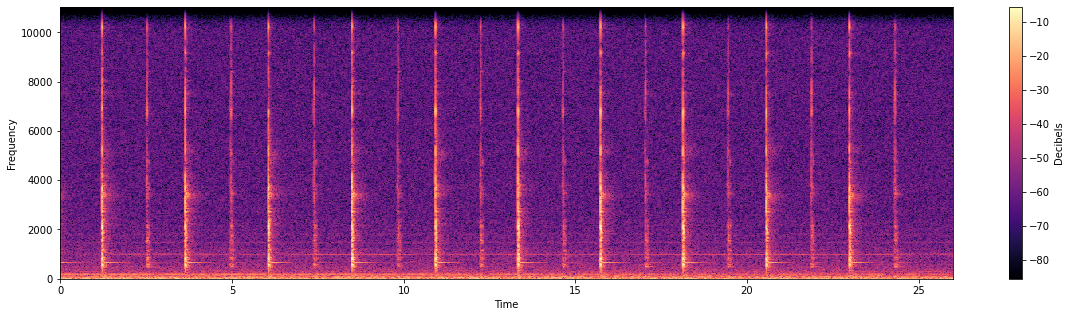

In [5]:

view_specrogram('Engineering_212.wav')

22050


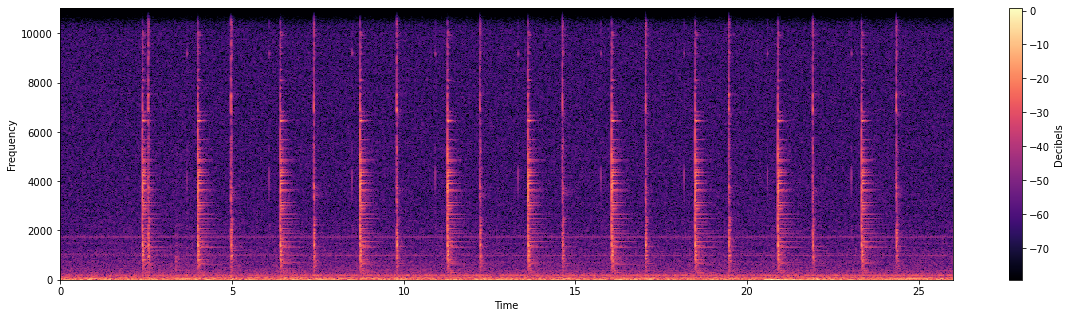

In [6]:
view_specrogram('Galvanised_45.wav')

22050


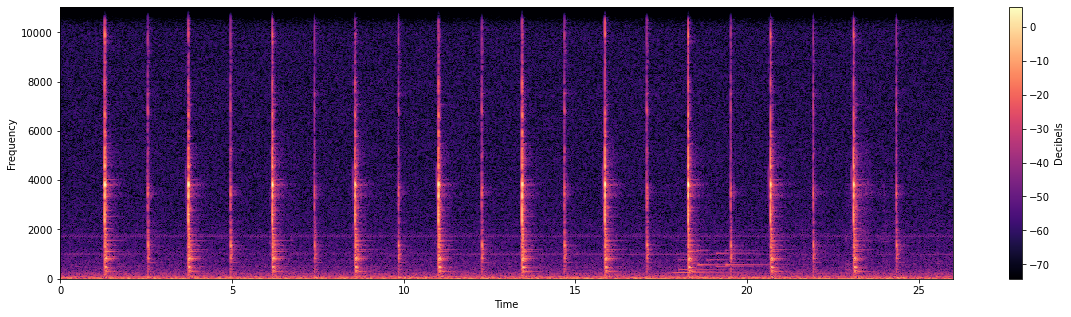

In [7]:
view_specrogram('Stainless_88.wav')